In [60]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sklearn as sk

In [61]:
df = pl.read_parquet(r'D:\20240826_week8\metashape\20241029_products_uav_data\output\extract\polygon_df\plot_10.parquet')
df =df.drop(['distance_xy','angle_rad','vaa_rad','vaa_temp'])
df

FileNotFoundError: The system cannot find the path specified. (os error 3): ...826_week8\metashape\20241029_products_uav_data\output\extract\polygon_df\plot_10.parquet (set POLARS_VERBOSE=1 to see full path)

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


(array([1.91000e+02, 2.65400e+03, 1.50870e+04, 3.20600e+04, 4.89010e+04,
        6.49300e+04, 8.22850e+04, 1.03561e+05, 1.29600e+05, 1.61124e+05,
        1.96702e+05, 2.35627e+05, 2.73477e+05, 3.12292e+05, 3.44232e+05,
        3.67637e+05, 3.85820e+05, 3.96650e+05, 4.02744e+05, 4.02291e+05,
        4.01042e+05, 3.94412e+05, 3.89526e+05, 3.83958e+05, 3.77864e+05,
        3.75315e+05, 3.69740e+05, 3.66217e+05, 3.62836e+05, 3.59171e+05,
        3.54228e+05, 3.51464e+05, 3.48141e+05, 3.47243e+05, 3.41939e+05,
        3.38614e+05, 3.36869e+05, 3.30183e+05, 3.25744e+05, 3.19002e+05,
        3.12339e+05, 3.02993e+05, 2.92538e+05, 2.80610e+05, 2.66896e+05,
        2.52717e+05, 2.35195e+05, 2.18658e+05, 2.00884e+05, 1.82767e+05,
        1.64699e+05, 1.46263e+05, 1.29401e+05, 1.11923e+05, 9.57000e+04,
        8.00470e+04, 6.71880e+04, 5.50850e+04, 4.40560e+04, 3.47290e+04,
        2.67740e+04, 2.05480e+04, 1.56550e+04, 1.17210e+04, 8.70300e+03,
        6.42000e+03, 4.53700e+03, 3.30900e+03, 2.29

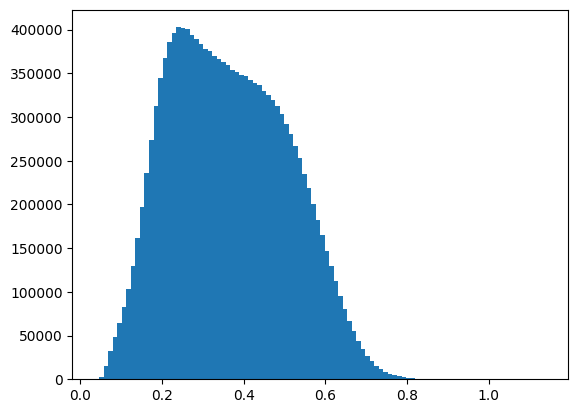

In [31]:
import random
np.random.seed(42)
subset = df.sample(n=100000, with_replacement=True, shuffle=True, seed=42)
plt.hist(df['band5'],bins=100)

In [34]:
df = df.with_columns([
    (pl.col("xcam") - pl.col("Xw")).alias("vx"),
    (pl.col("ycam") - pl.col("Yw")).alias("vy"),
    pl.col("delta_z").alias("vz"),            # already positive
])

df = df.with_columns(
    ((pl.col("vx")**2 + pl.col("vy")**2 + pl.col("vz")**2).sqrt()).alias("v_norm")
)

df = df.with_columns([
    pl.map_batches(["vz", "v_norm"], lambda zs:
           np.degrees(np.arccos(zs[0] / zs[1]))).alias("vza_deg_new"),

    pl.map_batches(["vx", "vy"], lambda xy:
           (np.degrees(np.arctan2(xy[0], xy[1])) % 360)
    ).alias("vaa_deg_new"),
])

df = df.with_columns([
    # Solar Zenith Angle (degrees)
    (90 - pl.col("sunelev")).alias("sza_deg"),
    #NDVI index
    (
            (pl.col('band5')- pl.col('band3')) /(pl.col('band5')+pl.col('band3'))
    ).alias("NDVI"),

    # View Zenith Angle (degrees)
    pl.col("vza").alias("vza_deg_new"),

    # Relative Azimuth Angle (degrees), wrapped to 0–180°
    (
        ((pl.col("saa") - pl.col("vaa_deg_new")).abs() % 360)              # raw |Δazimuth| ∈ [0, 360)
        .map_elements(                                             # clamp >180° to its supplement
            lambda x: x if x <= 180 else 360 - x,
            return_dtype=pl.Float32
        )
    ).alias("raa_deg"),

])



df

Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path,vx,vy,vz,v_norm,vza_deg_new,vaa_deg_new,sza_deg,raa_deg,NDVI
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f32,f64,f32,f32,f32,f32,str,f64,f64,f32,f64,f32,f64,f32,f32,f32
563623.664805,5.7130e6,0.006305,0.015863,0.012691,0.056138,0.192968,187.995102,"""plot_2""",19.624176,-0.477305,25.869808,52.82,200.016085,563623.1875,5.713045e6,52.87006,158.92691,"""IMG_0102_6.tif""",-0.477305,25.869808,19.624176,32.474345,52.82,358.942998,37.12994,159.983917,0.876584
563623.672056,5.7130e6,0.006918,0.017357,0.011724,0.057851,0.20568,187.989044,"""plot_2""",19.630234,-0.484556,25.869717,52.810001,200.000027,563623.1875,5.713045e6,52.87006,158.92691,"""IMG_0102_6.tif""",-0.484556,25.869717,19.630234,32.478041,52.810001,358.926939,37.12994,159.999969,0.892149
563623.664896,5.7130e6,0.007864,0.017625,0.02095,0.061805,0.185946,188.000961,"""plot_2""",19.618317,-0.477396,25.877059,52.84,200.01618,563623.1875,5.713045e6,52.87006,158.92691,"""IMG_0102_6.tif""",-0.477396,25.877059,19.618317,32.476583,52.84,358.943092,37.12994,159.98381,0.797487
563623.672147,5.7130e6,0.010482,0.020803,0.026263,0.067292,0.224892,187.994461,"""plot_2""",19.624817,-0.484647,25.876968,52.830002,200.000126,563623.1875,5.713045e6,52.87006,158.92691,"""IMG_0102_6.tif""",-0.484647,25.876968,19.624817,32.480545,52.830002,358.927039,37.12994,159.999878,0.790864
563623.679398,5.7130e6,0.011554,0.022848,0.023692,0.06201,0.203382,187.988693,"""plot_2""",19.630585,-0.491898,25.876877,52.82,199.984072,563623.1875,5.713045e6,52.87006,158.92691,"""IMG_0102_6.tif""",-0.491898,25.876877,19.630585,32.484067,52.82,358.910985,37.12994,160.01593,0.791329
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563626.542794,5.7130e6,0.033494,0.111298,0.042385,0.244495,0.513763,187.883789,"""plot_2""",19.709015,-3.292794,1.848609,10.85,168.734922,563623.25,5713020.5,73.257988,130.575394,"""IMG_0091_6.tif""",-3.292794,1.848609,19.709015,20.067514,10.85,299.310317,16.742012,168.734924,0.847576
563626.550045,5.7130e6,0.014013,0.057645,0.018719,0.135121,0.309322,187.883011,"""plot_2""",19.709793,-3.300045,1.848518,10.86,168.679949,563623.25,5713020.5,73.257988,130.575394,"""IMG_0091_6.tif""",-3.300045,1.848518,19.709793,20.069461,10.86,299.255344,16.742012,168.679947,0.885875
563626.557296,5.7130e6,0.012341,0.048161,0.016317,0.106769,0.294317,187.88118,"""plot_2""",19.711624,-3.307296,1.848427,10.88,168.625158,563623.25,5713020.5,73.257988,130.575394,"""IMG_0091_6.tif""",-3.307296,1.848427,19.711624,20.072444,10.88,299.200553,16.742012,168.625153,0.894941


In [35]:
def rpv(angle_pack, rho0, k, theta):
    s, v, f = angle_pack
    # deg → rad
    s = np.radians(s);  v = np.radians(v);  f = np.radians(f)
    cos_s, cos_v = np.cos(s), np.cos(v)
    F = 1 + theta * np.cos(f)              # simple phase kernel
    return rho0 * (cos_s**k) * (cos_v**k) * F

0.35030466
ρ₀=0.3765,  k=0.092,  θ=0.000
RMSE=0.1433,  nRMSE=39.4%


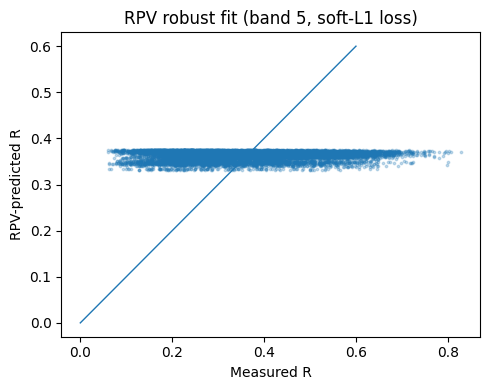

In [36]:
import numpy as np, polars as pl, matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

band = "band5"

# ── 1. Pull filtered pixels to NumPy ───────────────────────────────
df_fit = (
    df.filter((pl.col(band).is_finite()) &
              (pl.col(band) > 0) & (pl.col(band) < 1)).sample(n=10000, with_replacement=True, shuffle=True, seed=42)
)

sza  = df_fit["sza_deg"].to_numpy()
vza  = df_fit["vza_deg_new"].to_numpy()
raa  = df_fit["raa_deg"].to_numpy()
R    = df_fit[band].to_numpy()

print(np.median(R))

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
sza, vza, raa, R = [x[mask] for x in (sza, vza, raa, R)]

# ── 2. Define residual for least_squares ───────────────────────────
def rpv_res(pars, sza, vza, raa, R):
    return rpv((sza, vza, raa), *pars) - R

# initial guess & bounds
p0      = [np.median(R), 1.2, 0.3]
bounds  = ([0, 0, 0], [2, 5, 2])

# ── 3. Robust fit ---------------------------------------------------
res = least_squares(
        rpv_res, p0, bounds=bounds,
        args=(sza, vza, raa, R),
        loss="soft_l1",
        max_nfev=30000, verbose=0
)

rho0, k, theta = res.x
print(f"ρ₀={rho0:.4f},  k={k:.3f},  θ={theta:.3f}")

# ── 4. Evaluate metrics --------------------------------------------
R_hat = rpv((sza, vza, raa), rho0, k, theta)
rmse  = np.sqrt(mean_squared_error(R, R_hat))
nrmse = rmse / R.mean()
print(f"RMSE={rmse:.4f},  nRMSE={nrmse*100:.1f}%")

# ── 5. Scatter plot -------------------------------------------------
plt.figure(figsize=(5,4))
plt.scatter(R, R_hat, s=3, alpha=0.25)
plt.plot([0, 0.6], [0, 0.6], lw=1)
plt.xlabel("Measured R"); plt.ylabel("RPV-predicted R")
plt.title("RPV robust fit (band 5, soft-L1 loss)")
plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'VZA distribution')

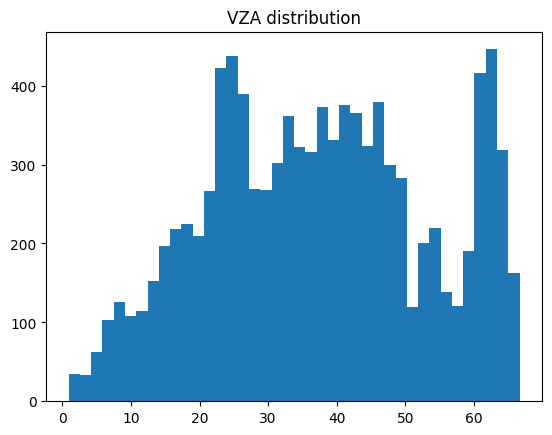

In [37]:
  plt.hist(vza, bins=40); plt.title("VZA distribution")

min / max : 0.036110129207372665 1.1392297744750977


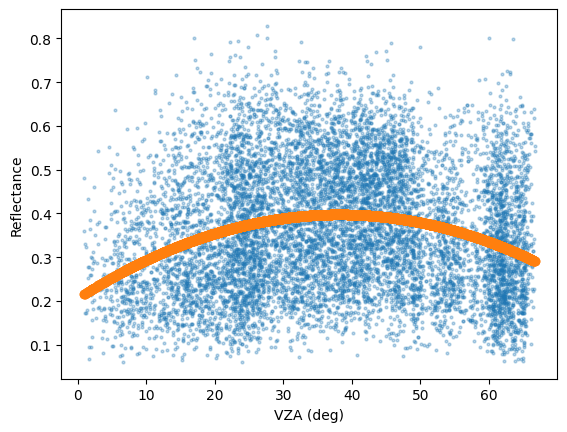

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# 1. Is reflectance well-scaled?
print("min / max :", df[band].min(), df[band].max())

# 2. Do we see any BRDF slope?
plt.scatter(df_fit["vza_deg_new"], df_fit[band], s=4, alpha=0.3)

poly = PolynomialFeatures(degree=2)
polynomial_feature = poly.fit_transform(df_fit["vza_deg_new"].to_numpy().reshape(-1, 1))

poly_reg_model = LinearRegression()
poly_reg_model.fit(polynomial_feature, df_fit[band])
y_predicted = poly_reg_model.predict(polynomial_feature)


plt.scatter(df_fit["vza_deg_new"],y_predicted, lw=1)


plt.xlabel("VZA (deg)"); plt.ylabel("Reflectance"); plt.show()



ρ₀,k,θ: [ 0.3770315   0.09506979 -0.0089921 ]


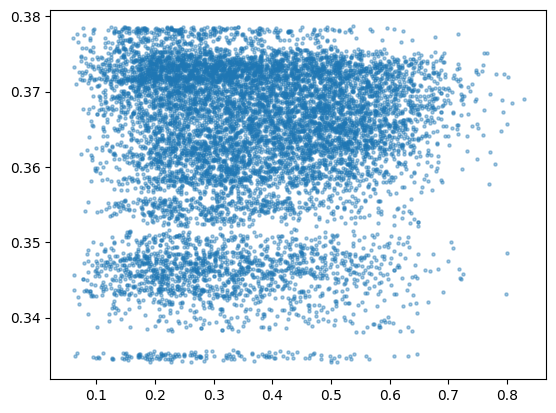

In [39]:
from scipy.optimize import curve_fit

# 3. Hard-trim obvious junk and refit
df_fit = df_fit.filter(
    (pl.col(band).is_finite()) &
    (pl.col(band) > 0.01) &          # drop ultrasmall noise
    (pl.col(band) < 0.9)            # drop clouds / glare
)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[3, -2, -2])
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);
plt.show()


ρ₀,k,θ: [2.35042137e-01 2.05684937e-12 2.15411521e-19]


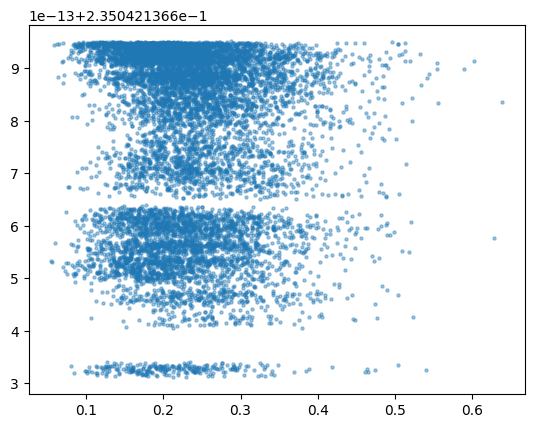

In [40]:

df_fit = df.filter((pl.col("NDVI") > 0.9) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[np.median(R), 1.0, 0.1], bounds=(0, [1, 5, 1]))
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);  plt.show()

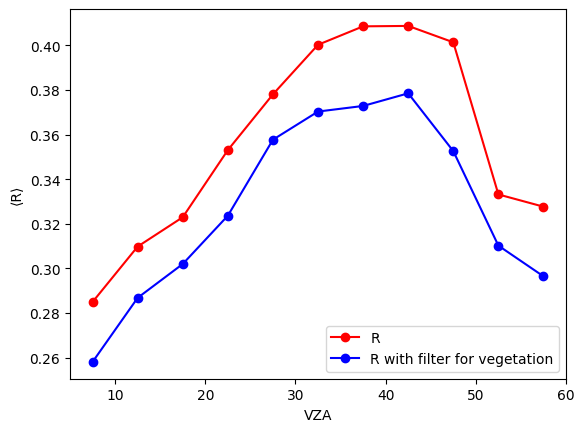

In [59]:

band = 'band5'

 #NO vegetation filter
df_fit = df.filter((pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)


sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

bins  = np.arange(5, 65, 5)
digit = np.digitize(vza, bins)
R_mean = [R[digit==i].mean() for i in range(1, len(bins))]
plt.plot(bins[:-1]+2.5, R_mean, 'o-',color='r', label='R')
plt.xlabel("VZA")
plt.ylabel("⟨R⟩")



 #With vegetation filter

df_fit = df.filter((pl.col("NDVI") > 0.8) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

bins  = np.arange(5, 65, 5)
digit = np.digitize(vza, bins)
R_mean = [R[digit==i].mean() for i in range(1, len(bins))]
plt.plot(bins[:-1]+2.5, R_mean, 'o-',color='b', label='R with filter for vegetation')

plt.legend(loc='best')
plt.show()

C:\Users\dadoi\AppData\Local\Temp\ipykernel_10784\1588378869.py:11: RuntimeWarning: Mean of empty slice.
  mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
C:\Users\dadoi\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


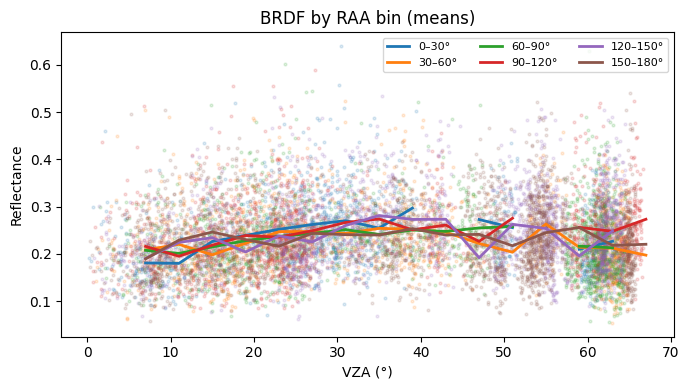

In [42]:
bins = np.arange(0, 181, 30)
col  = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]

plt.figure(figsize=(7,4))
for i in range(len(bins)-1):
    sel = (raa>=bins[i]) & (raa<bins[i+1])
    # scatter cloud, but no label -> omitted from legend
    plt.scatter(vza[sel], R[sel], s=4, alpha=0.15, c=col[i])
    # robust central tendency per 4° VZA bin
    vza_bin = np.arange(5, 66, 4)
    mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
    plt.plot(vza_bin+2, mean_R, c=col[i], lw=2, label=f"{bins[i]}–{bins[i+1]}°")

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF by RAA bin (means)")
plt.legend(fontsize=8, ncol=3)
plt.tight_layout(); plt.show()


C:\Users\dadoi\AppData\Local\Temp\ipykernel_10784\3532487275.py:12: RuntimeWarning: Mean of empty slice.
  meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]


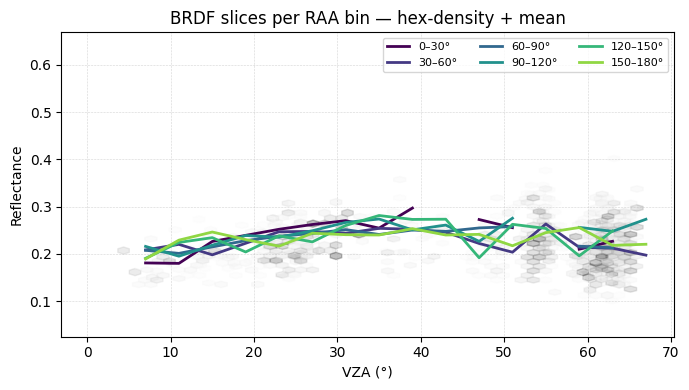

In [43]:
bins     = np.arange(0, 181, 30)
base_cmap = plt.get_cmap("viridis")
colors   = [base_cmap(i/6) for i in range(6)]
vza_bin  = np.arange(5, 66, 4)

plt.figure(figsize=(7,4))
for i,(lo,hi) in enumerate(zip(bins[:-1], bins[1:])):
    sel = (raa>=lo) & (raa<hi)
    plt.hexbin(vza[sel], R[sel], gridsize=45,
               cmap=plt.get_cmap("Greys"),
               alpha=0.25, mincnt=4)
    meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]
    plt.plot(vza_bin+2, meanR, c=colors[i], lw=2,
             label=f"{lo}–{hi}°")

plt.xlabel("VZA (°)");  plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — hex-density + mean")
plt.grid(ls=":", lw=0.4);  plt.legend(ncol=3, fontsize=8)
plt.tight_layout();  plt.show()

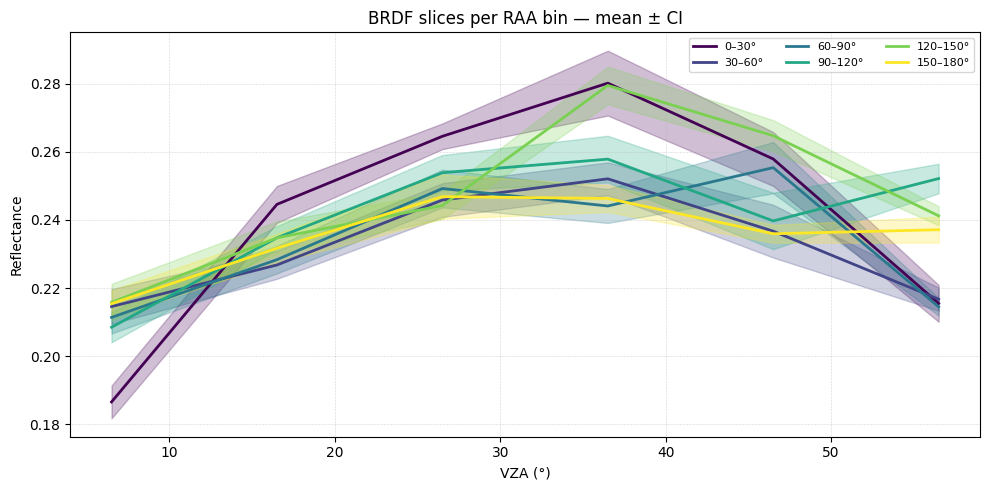

In [44]:
import numpy as np, matplotlib.pyplot as plt

# parameters
bins_raa   = np.arange(0, 181, 30)
bins_vza   = np.arange(5, 66, 10)                 # 3° rolling step
colors     = plt.get_cmap("viridis")(np.linspace(0, 1, len(bins_raa)-1))

plt.figure(figsize=(10, 5))


for i, (lo, hi) in enumerate(zip(bins_raa[:-1], bins_raa[1:])):

    sel = (raa >= lo) & (raa < hi)

    idx = np.digitize(vza[sel], bins_vza) - 1     # map each VZA to a bin

    means, sigmas, counts = [], [], []

    for b in range(len(bins_vza)-1):
        r = R[sel][idx == b]
        if r.size:                                # skip empty bins
            means.append(r.mean())
            sigmas.append(r.std() / np.sqrt(r.size))
            counts.append(bins_vza[b] + 1.5)      # bin centre
    plt.plot(counts, means, c=colors[i], lw=2, label=f"{lo}–{hi}°")
    plt.fill_between(counts, np.array(means)-sigmas, np.array(means)+sigmas,
                     color=colors[i], alpha=0.25)

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — mean ± CI"); plt.grid(ls=":", lw=0.4)
plt.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()


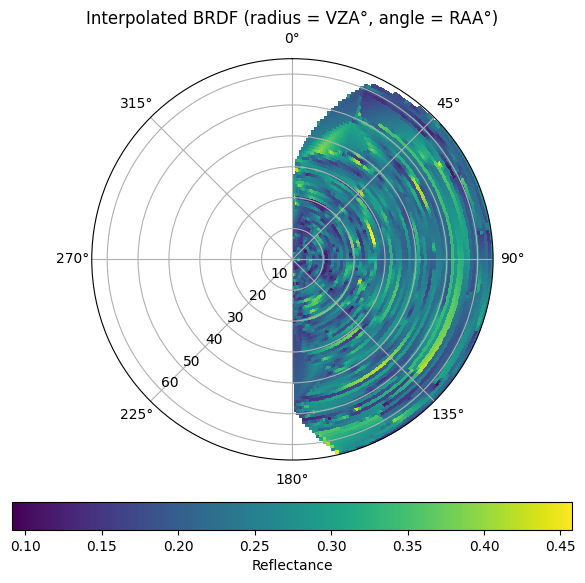

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# assume arrays raa (deg 0‑180), vza (deg 0‑65), R (reflectance) already exist
# substitute with your existing arrays when integrating

# --- 1. build regular grid ---------------------------------------------------
theta = np.linspace(0, np.pi, 181)          # 0‑180° → radians for polar
radius = np.linspace(0, 65, 66)             # VZA grid (deg)
T, R_grid = np.meshgrid(theta, radius)

# --- 2. interpolate reflectance onto grid ------------------------------------
points = np.column_stack((np.radians(raa), vza))   # original polar coords
values = R
Z = griddata(points, values, (T, R_grid), method='linear')

# mask empty cells for clarity
Z_masked = np.ma.masked_invalid(Z)

# --- 3. polar plot ------------------------------------------------------------
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
pcm = ax.pcolormesh(T, R_grid, Z_masked, shading='nearest', cmap='viridis')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)      # 0° = north, clockwise
ax.set_rlim(0, 65); ax.set_rlabel_position(225)
ax.set_title("Interpolated BRDF (radius = VZA°, angle = RAA°)")
cbar = plt.colorbar(pcm, orientation='horizontal', pad=0.08)
cbar.set_label("Reflectance")
plt.tight_layout()
plt.show()
